In [1]:
from collections import Counter
import os,re,string,json,math
from tqdm import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.collocations import *
from gensim.models.phrases import Phrases
from operator import itemgetter
from functions import *

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

plotting.style_()

tf = pd.read_csv(base_path + '/resources/keywords-corona-translation.csv')
tf_corona = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}

tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures"]} for k,v in tf_science.items()}

In [8]:
def find_top_collocates(bgfinder, vocabulary, seed_term, topn):
    list_scores = {w:bgfinder.score_ngram(bigram_measures.likelihood_ratio,seed_term,w) for w in vocabulary}
    list_scores = {k:v for k,v in list_scores.items() if v != None}
    return list(dict(sorted(list_scores.items(), key = itemgetter(1), reverse = True)[:topn]).keys())

def get_network(seed_term,bgfinder,vocabulary,topn):
    d = []
    for w1 in find_top_collocates(bgfinder, vocabulary, seed_term,topn):
        d.append([seed_term,w1])
        for w2 in find_top_collocates(bgfinder, vocabulary, w1,topn):
            d.append([w1,w2])
            for w3 in find_top_collocates(bgfinder, vocabulary, w2,topn):
                d.append([w2,w3])
    return pd.DataFrame(d,columns=['source','target'])

def collocation_month(language,df,month,seed_term,window_size=15,topn=6,plot=True,degree_limit=0):
    df = df[(df['id'].str.contains(month))]
    print(len(df),'texts selected')
    text = " ".join(df['text']).split(' ')
    finder = BigramCollocationFinder.from_words(text,window_size=window_size)
    d = get_network(seed_term,finder,set(text),topn)
    g = nx.from_pandas_edgelist(d, source='source', target='target',create_using=nx.DiGraph()) 
    dgrs = dict(g.degree)

    if degree_limit != 0:
        d = d[d['target'].isin([k for k,v in dgrs.items() if v >= degree_limit])]
        g = nx.from_pandas_edgelist(d, source='source', target='target',create_using=nx.DiGraph()) 
        dgrs = dict(g.degree)
    if plot == True:
        plt.figure(figsize=(25,15))
        layout = nx.spring_layout(g,k=1.15)

        nx.draw_networkx_nodes(g,layout,node_size=2,alpha=0)
        nx.draw_networkx_edges(g, layout, width=1.5, alpha=.75, edge_color="#cccccc",arrows=True,arrowstyle="-|>",arrowsize=50)
        
        for node, (x, y) in layout.items():
            plt.text(x, y, node, fontsize=math.log(dgrs[node] * 5) * 6, ha='center', va='center',color = "red" if node == seed_term else "black",bbox=dict(facecolor='red', alpha=0.1))
        plt.title(f"Collocation Network for seed term {seed_term.upper()} in {month} (Corpus: {language.upper()})",fontsize=24)
        plt.savefig(f'/home/ruben/Documents/GitHub/ParlaMintCase/results/plots/collocation-networks/collocation-network-{language}-{month}-{seed_term}-topn{topn}-ws{window_size}.png',dpi=250)

In [9]:
# Loading and subsetting

def clean_subset(iso,language):
    df = data_loader.load_month(iso,'2020-01','2021-03')
    df = df = df[df['text'].notna()]
    stopwords_ = nltk.corpus.stopwords.words(language)
    df['text'] = [[w for w in str(t).split(' ') if "_" in w and len(w.split('_')) != 1] for t in df['posner']]
    df['text'] = [" ".join([w.split('_')[0] for w in text if w.split('_')[1] in ['NOUN']]) for text in df['text']]
    df['text'] = [utils.preprocess(str(x),stopwords_) for x in tqdm(df['text'])]
    # df = df[df['text'].astype(str).str.contains("|".join(list(tf_corona[iso].values())))].reset_index(drop=True)
    print("size after subsetting:",len(df))
    return df.drop(['lemmatized','posner','title'],axis=1)

100%|██████████| 61573/61573 [00:03<00:00, 17860.70it/s]
size after subsetting: 61573
6699 texts selected
6699 texts selected
2442 texts selected
2442 texts selected
4611 texts selected
4611 texts selected
9789 texts selected
9789 texts selected
100%|██████████| 5204/5204 [00:02<00:00, 1937.96it/s]
size after subsetting: 5204
241 texts selected
241 texts selected
383 texts selected
383 texts selected
613 texts selected
613 texts selected
684 texts selected
684 texts selected
100%|██████████| 108354/108354 [00:14<00:00, 7551.66it/s]
size after subsetting: 108354
9184 texts selected
9184 texts selected
1975 texts selected
1975 texts selected
4894 texts selected
<ipython-input-8-902b9e5c28cb>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,15)

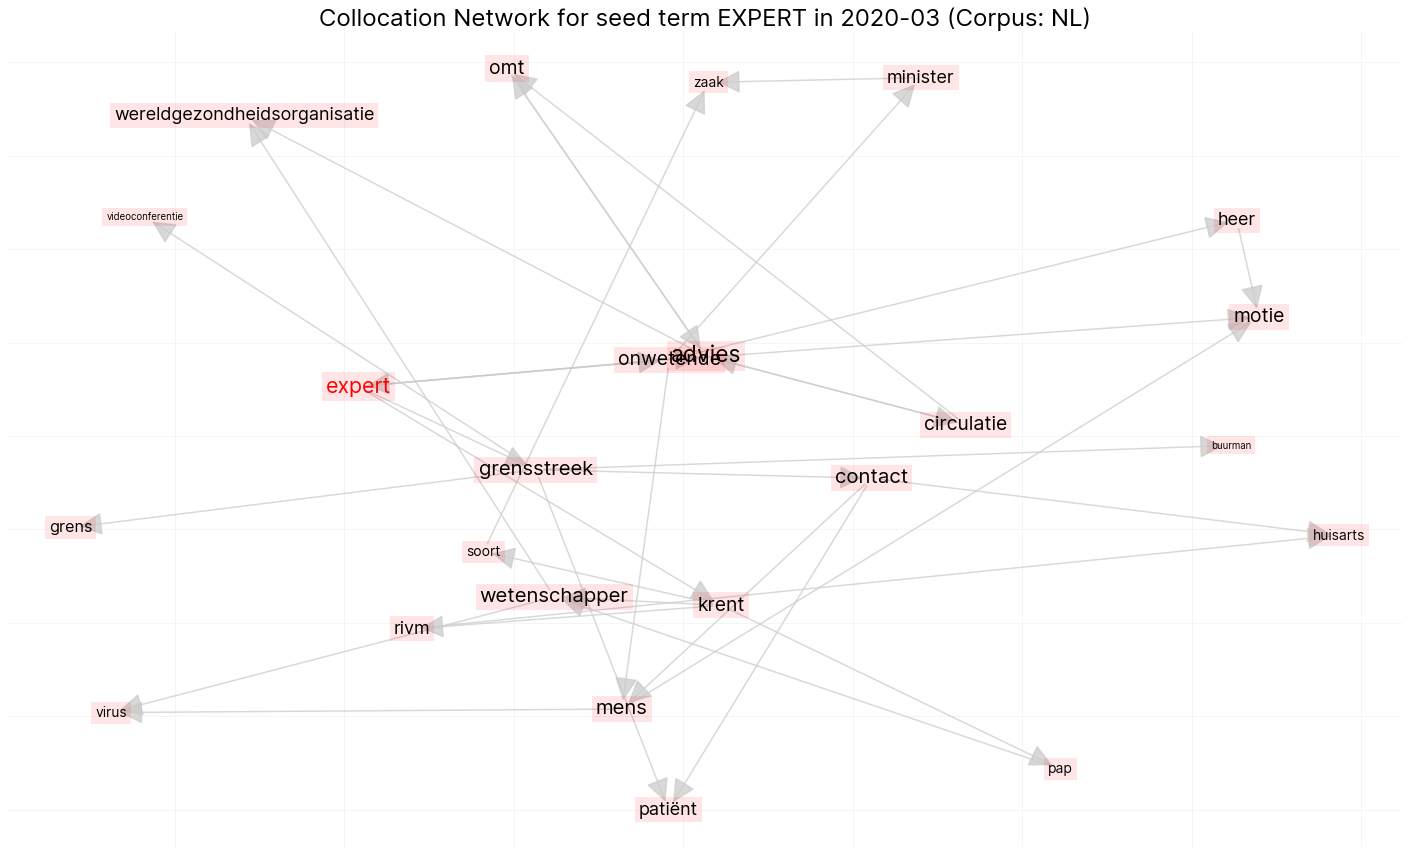

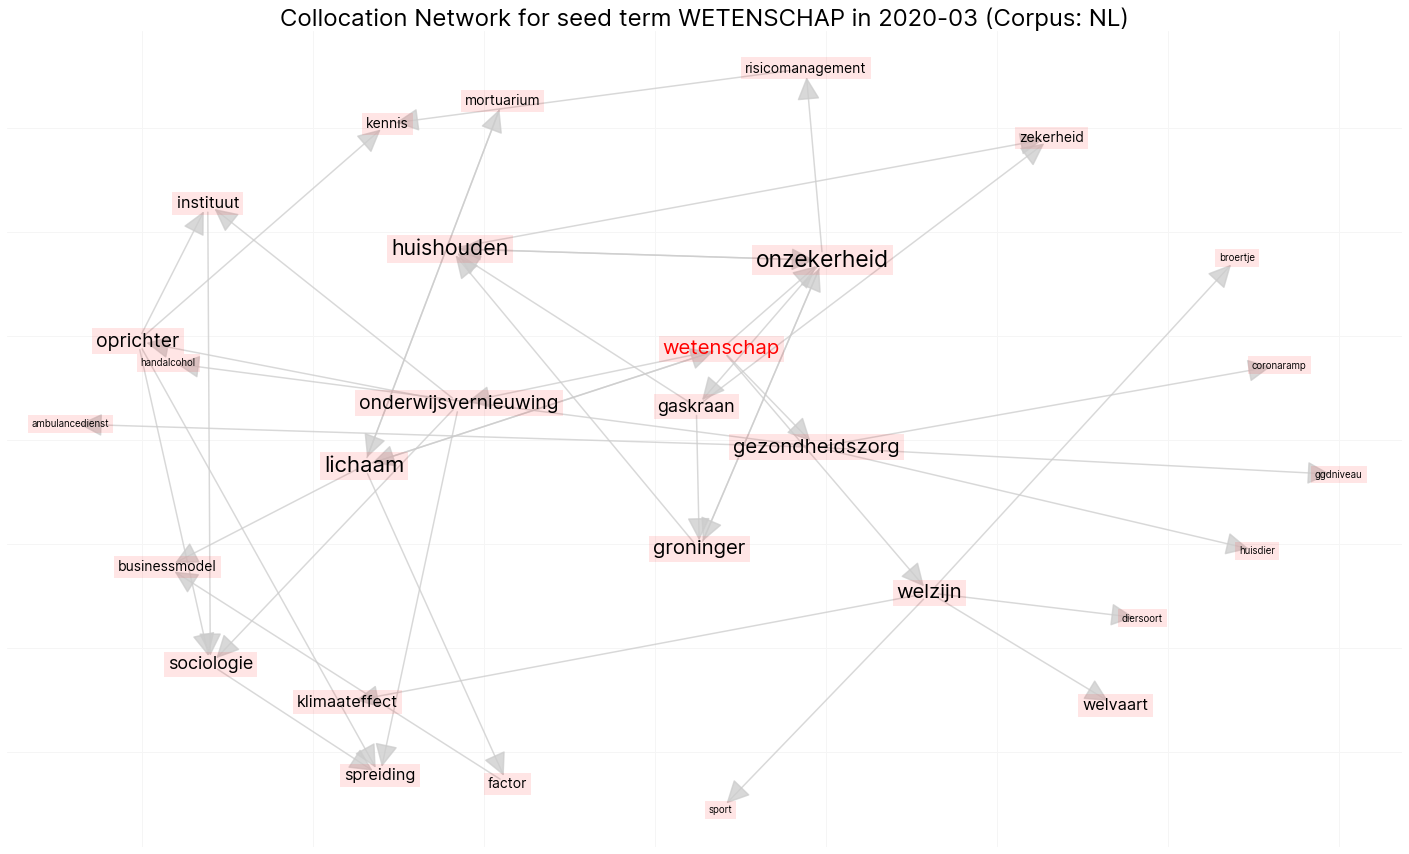

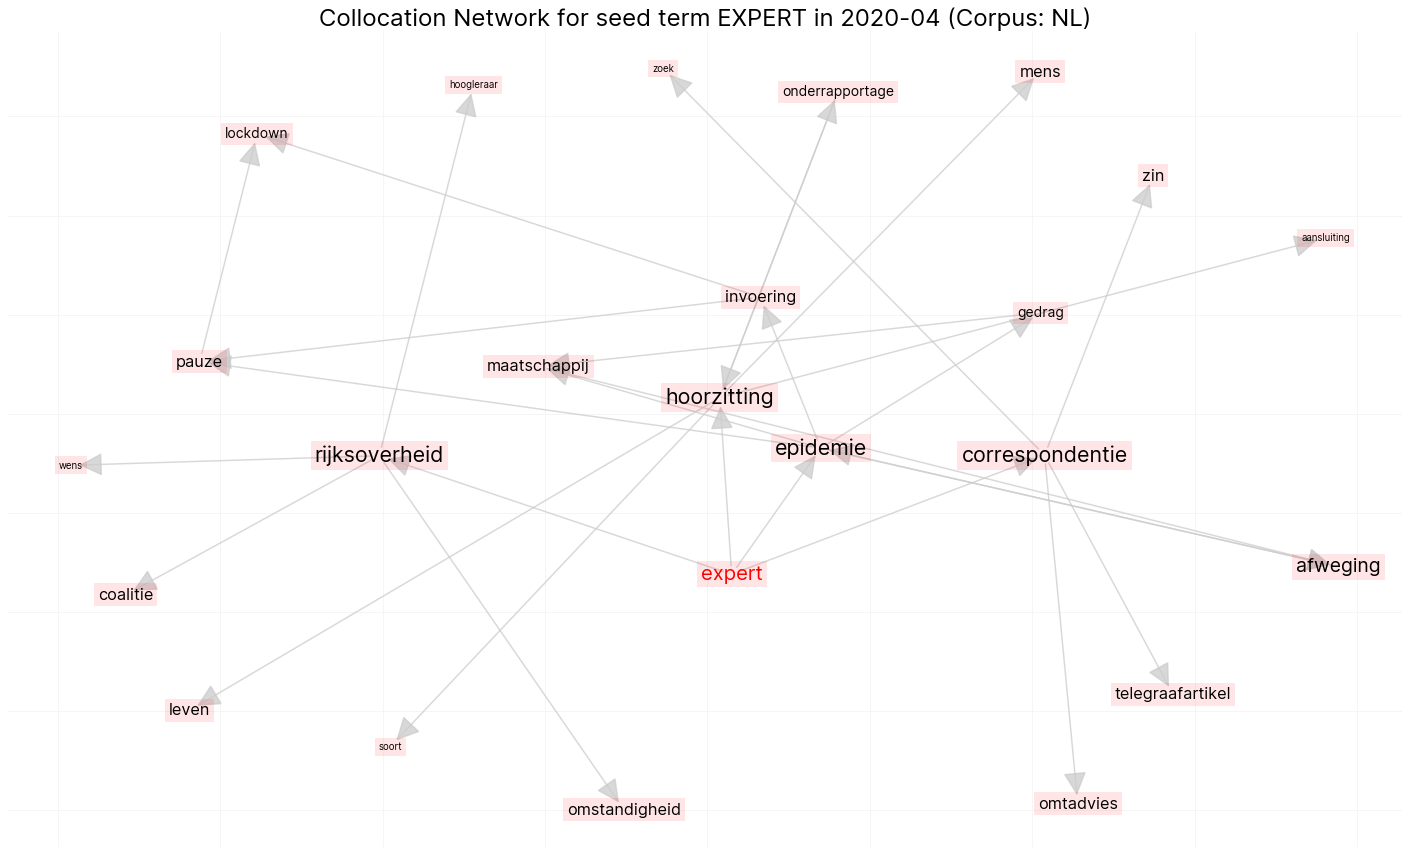

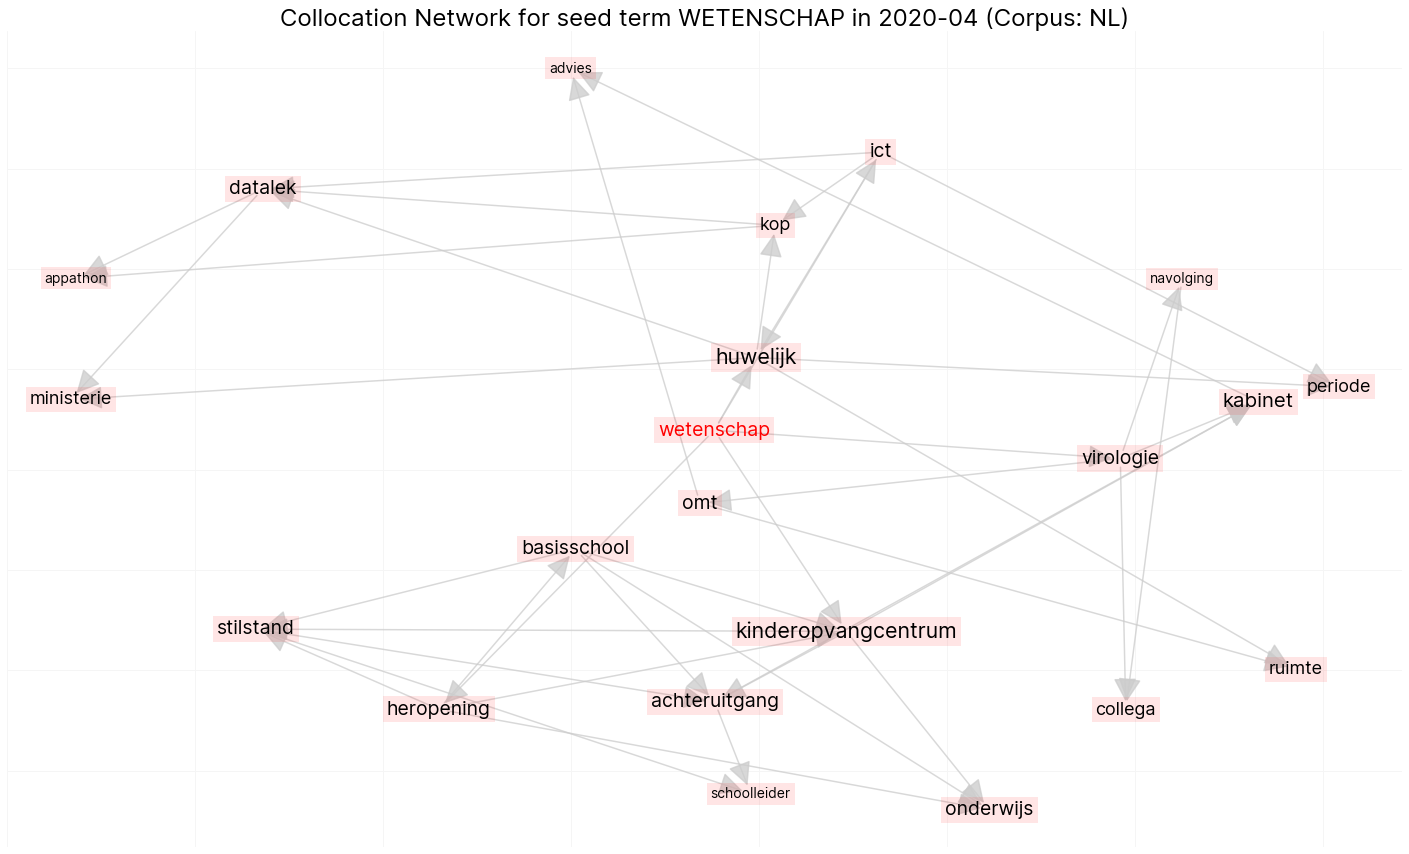

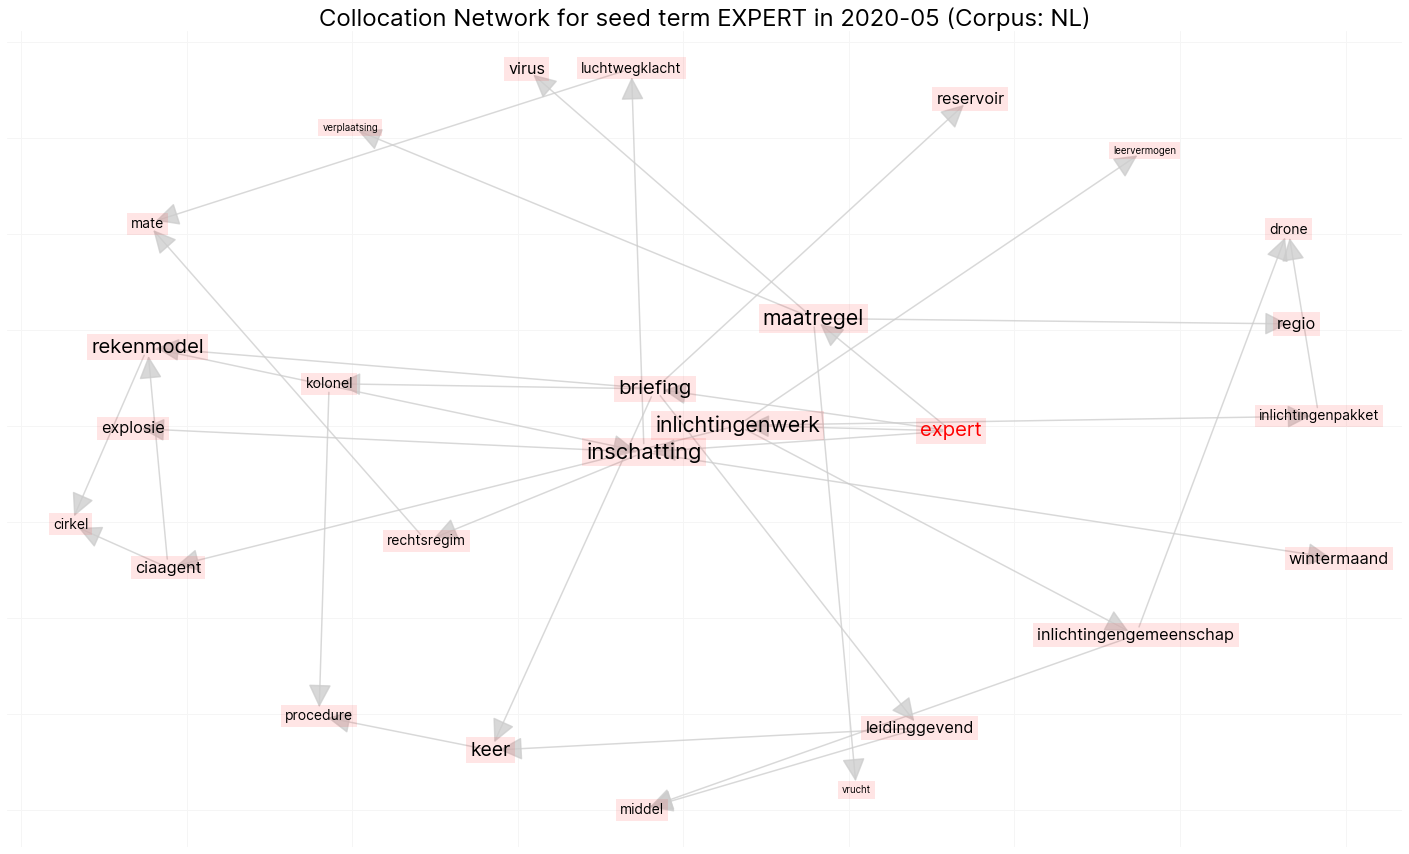

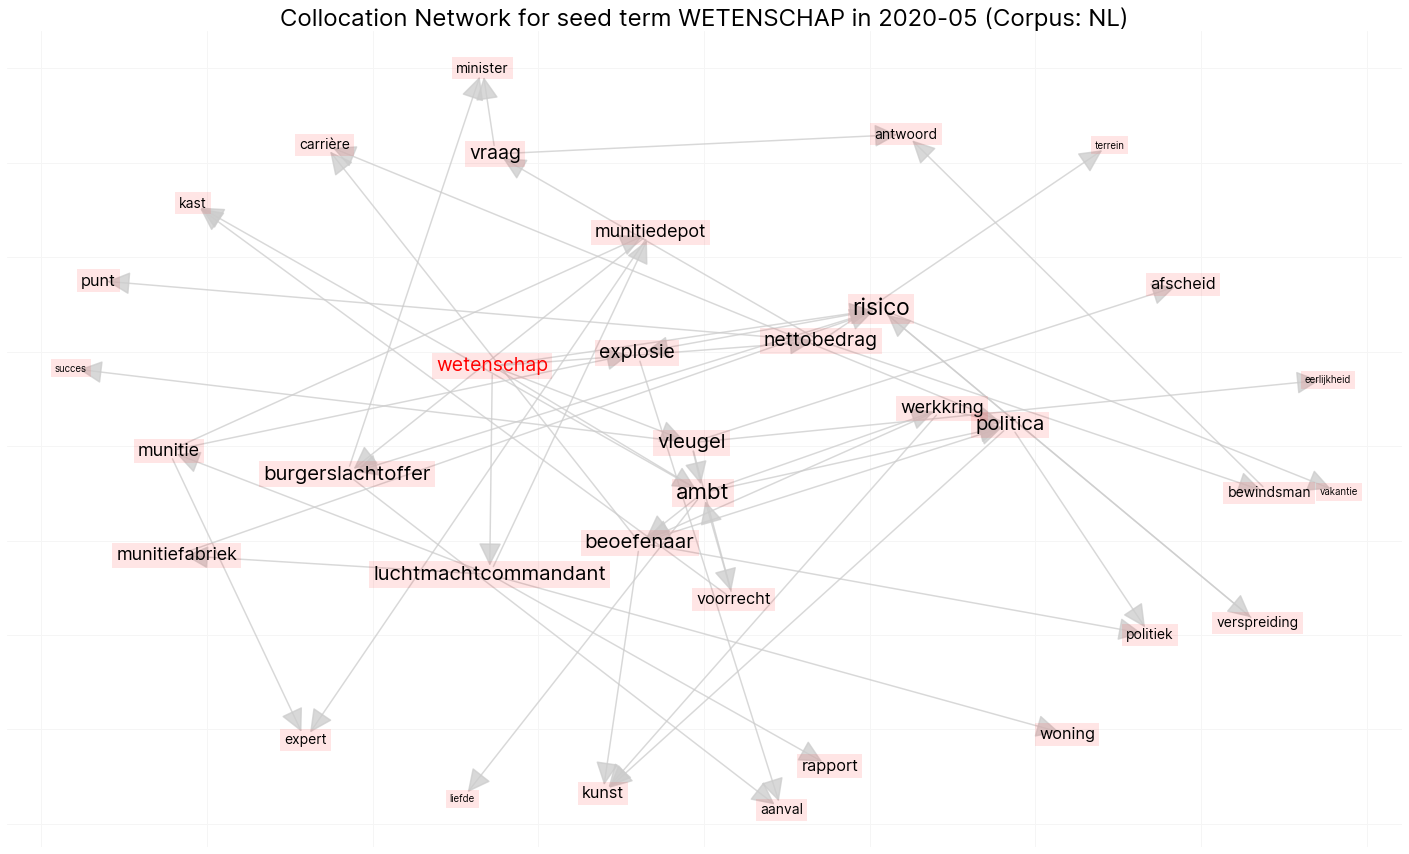

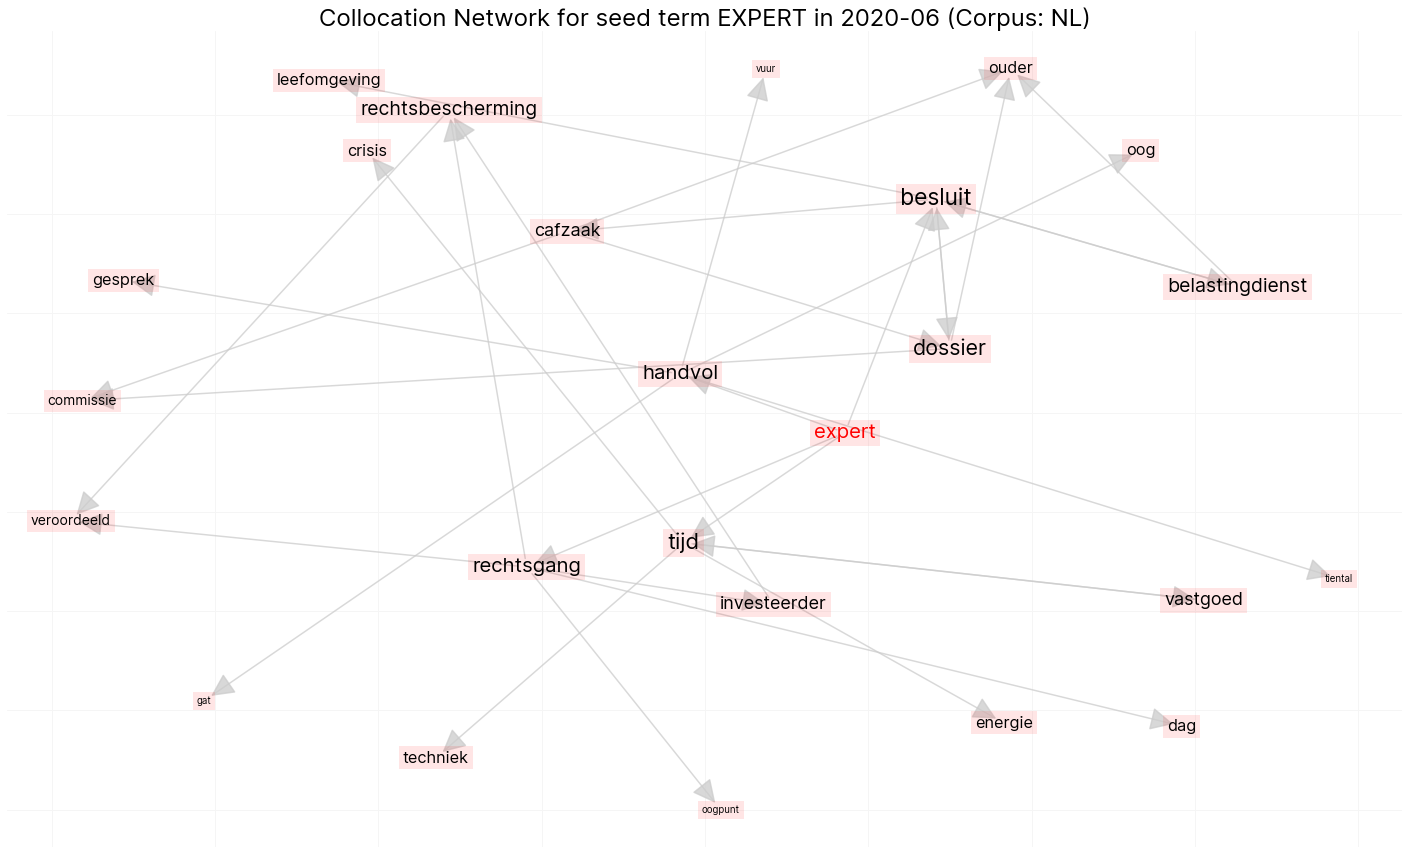

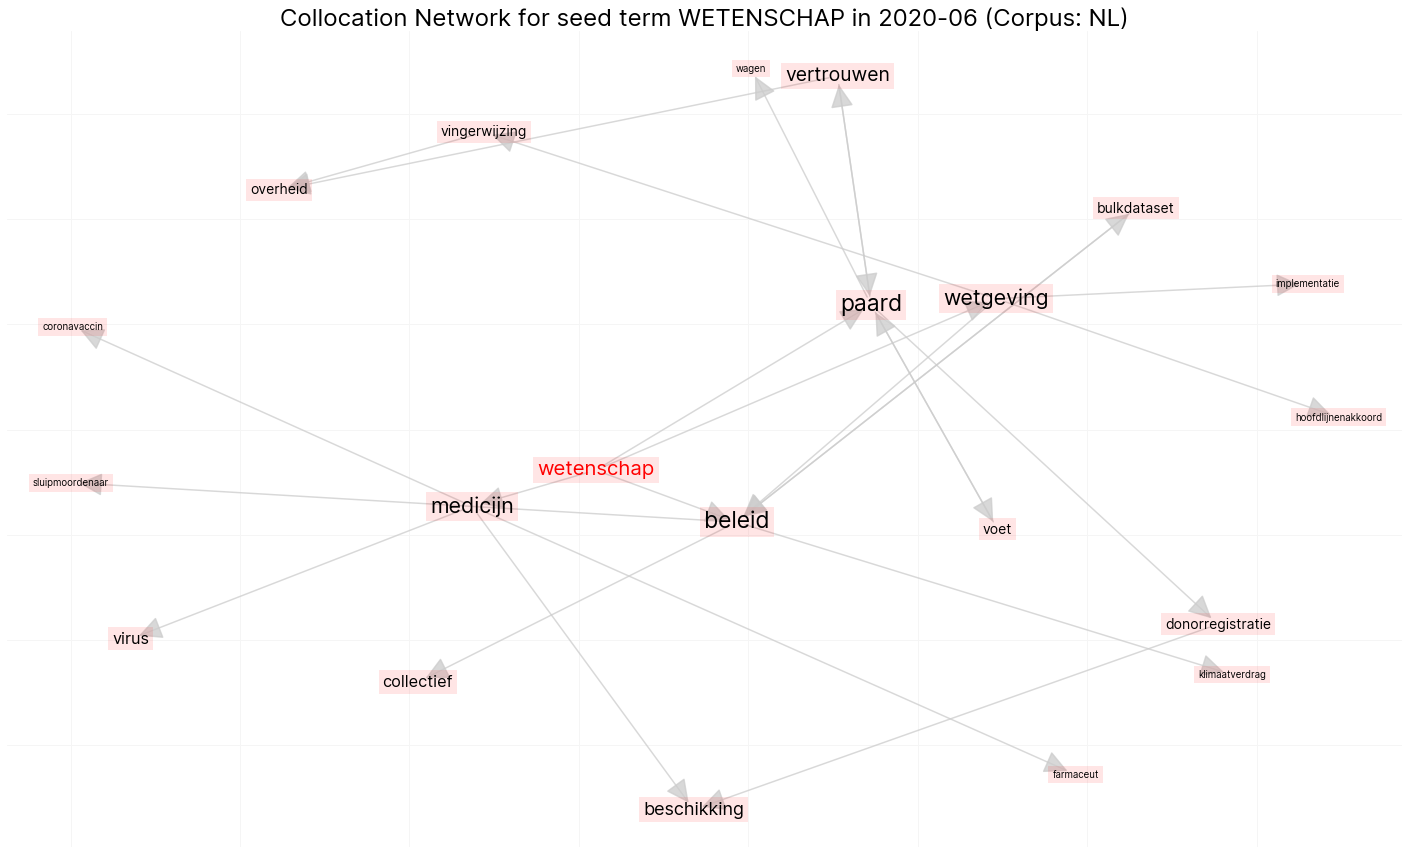

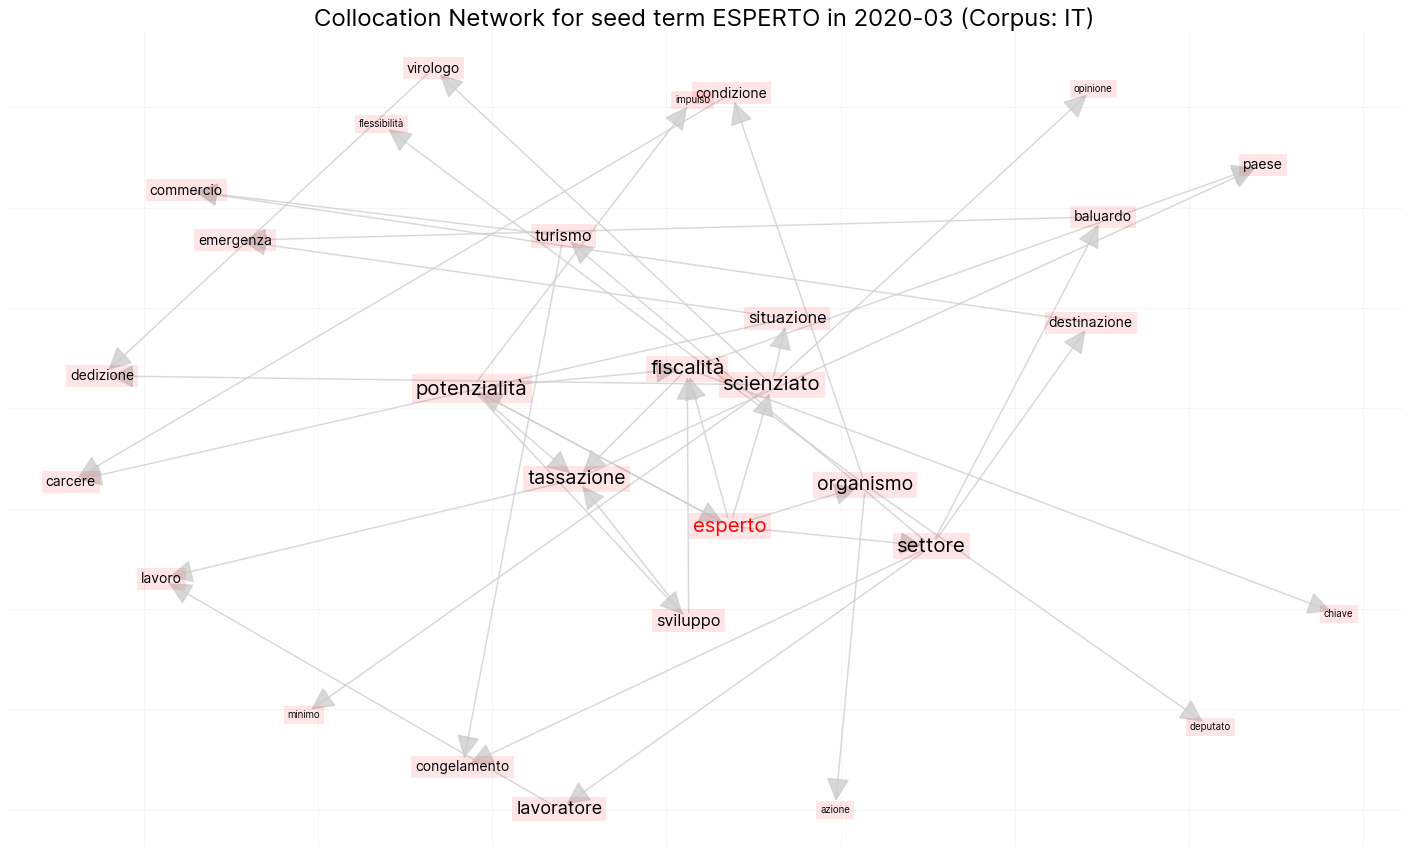

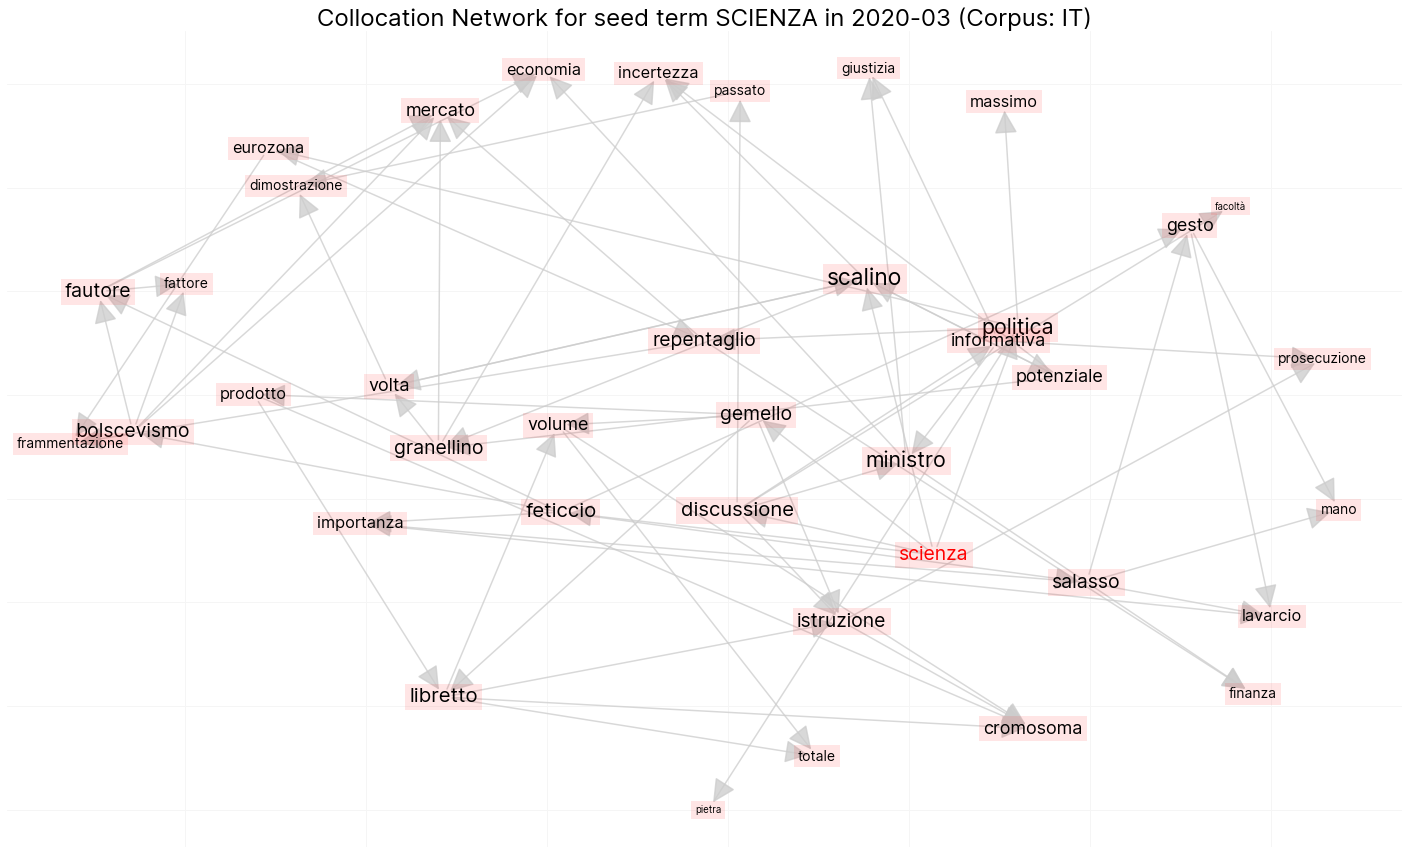

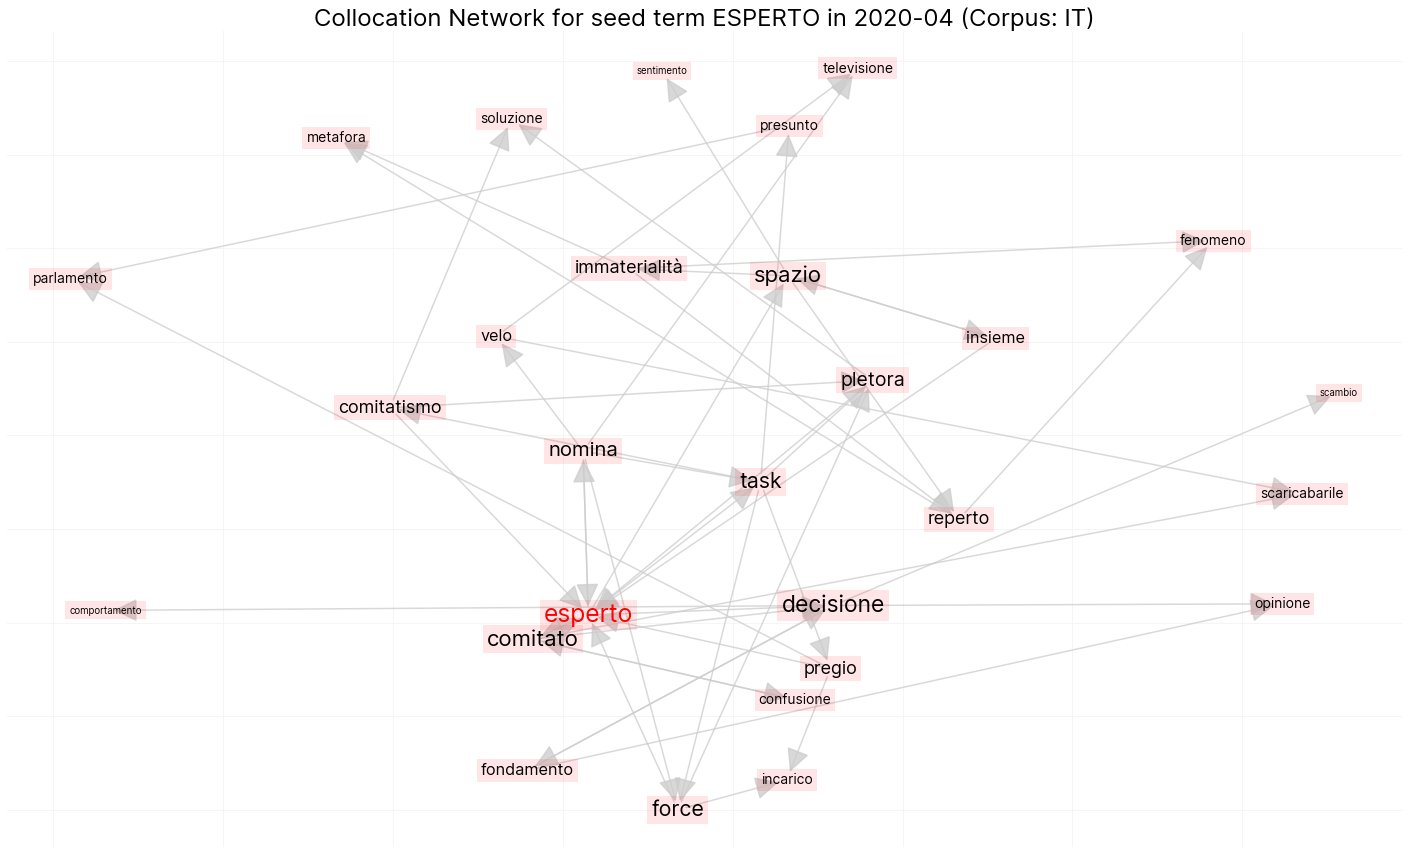

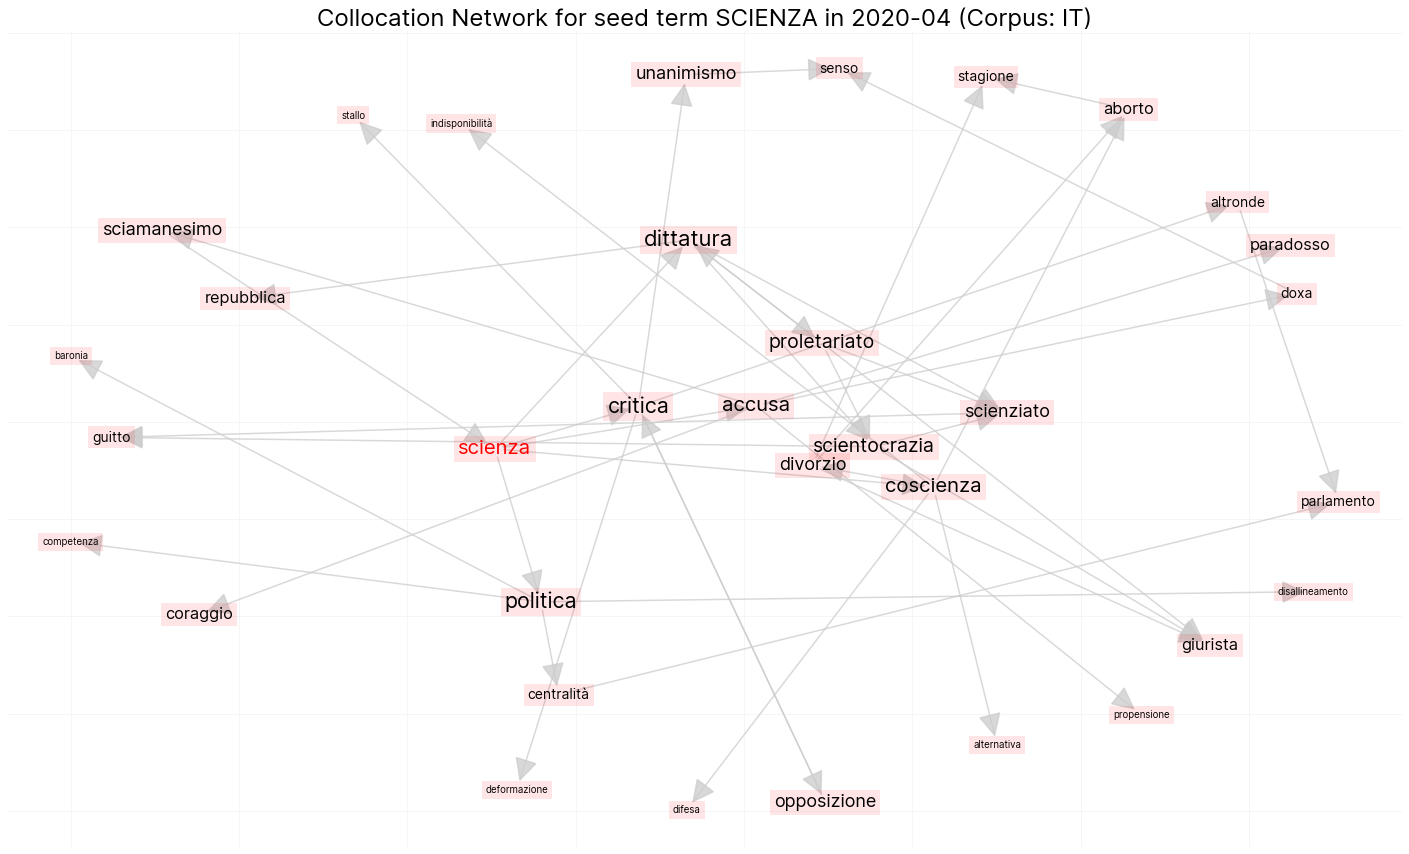

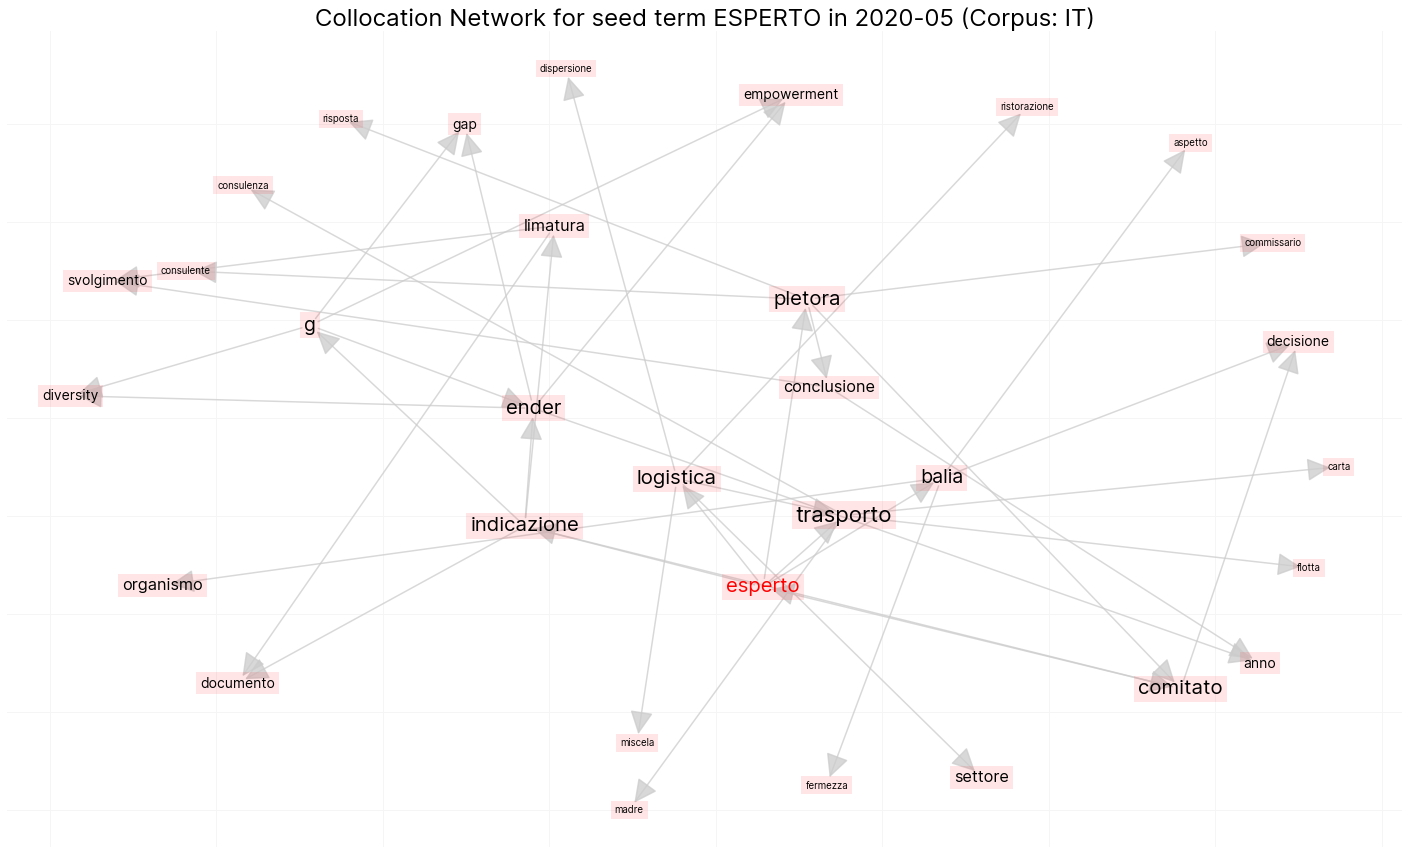

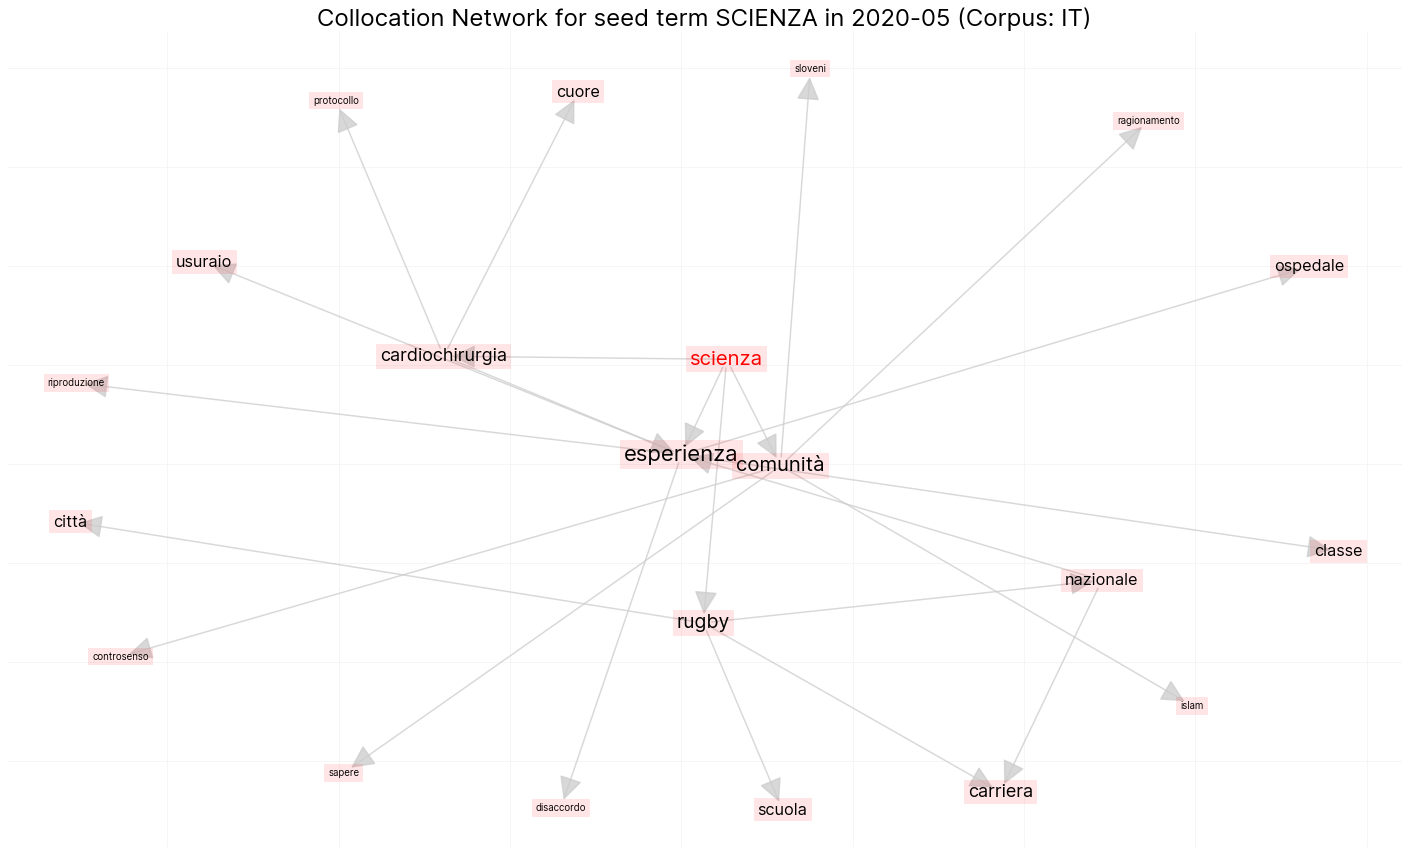

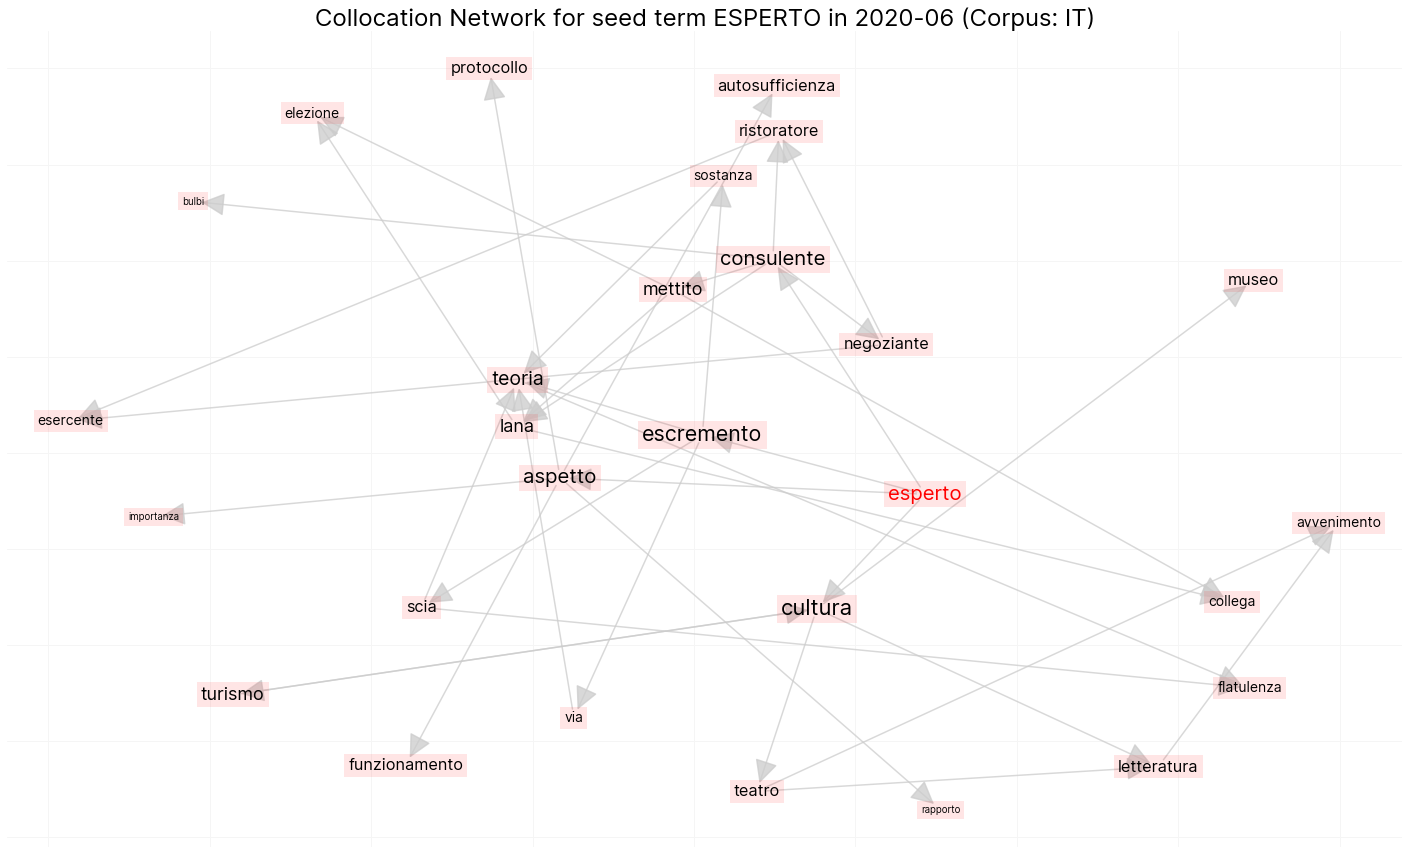

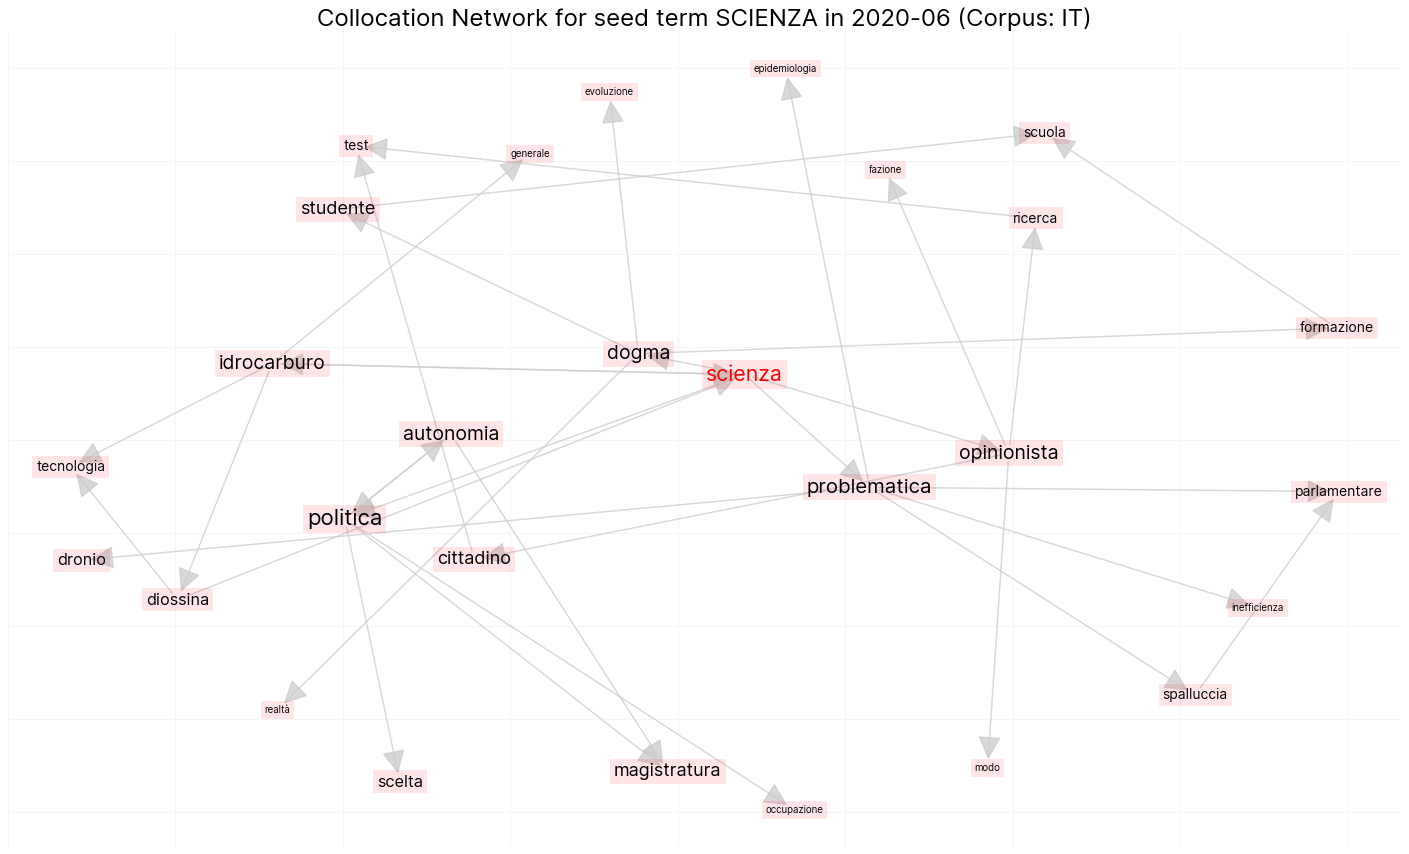

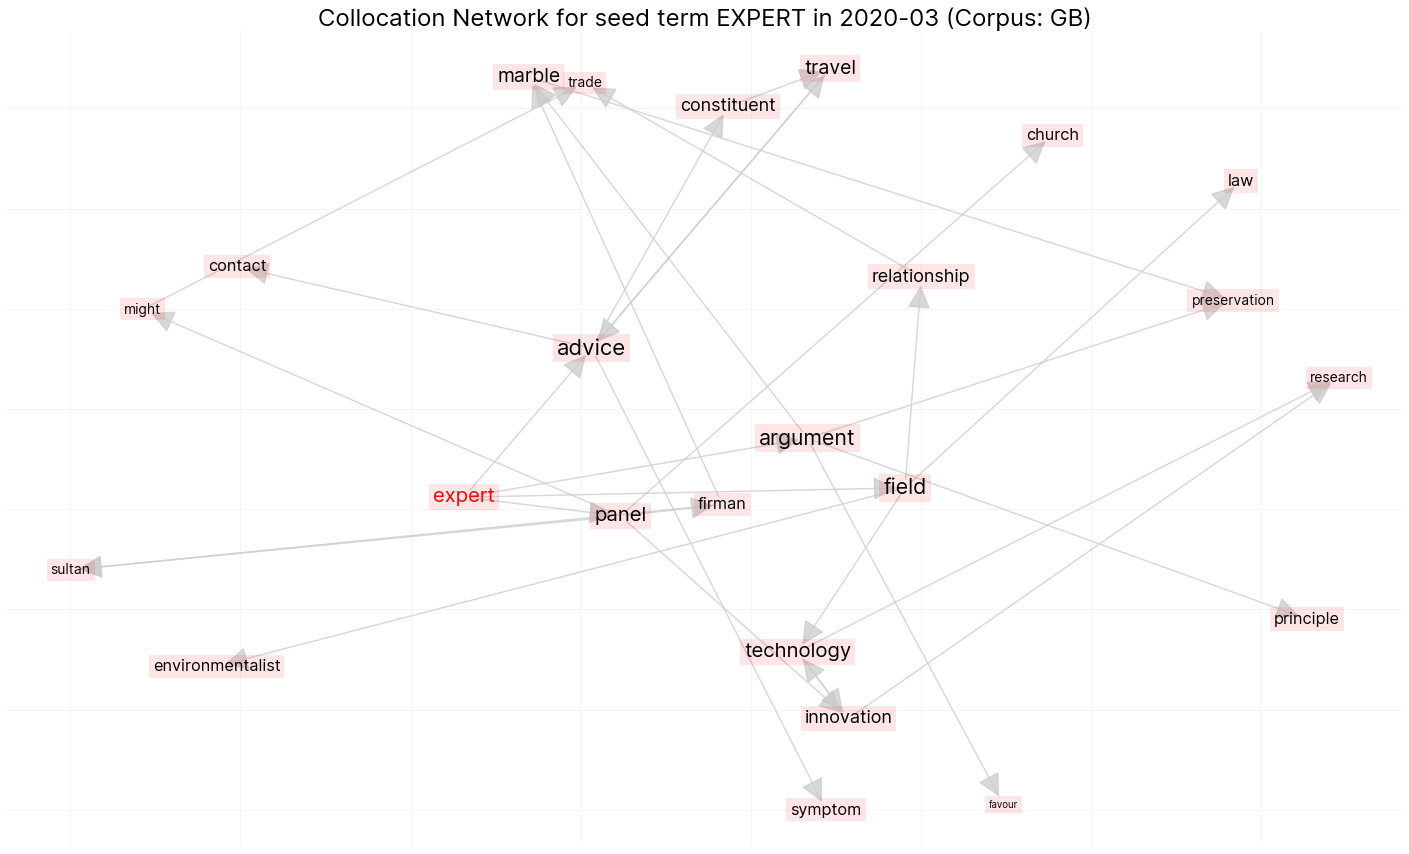

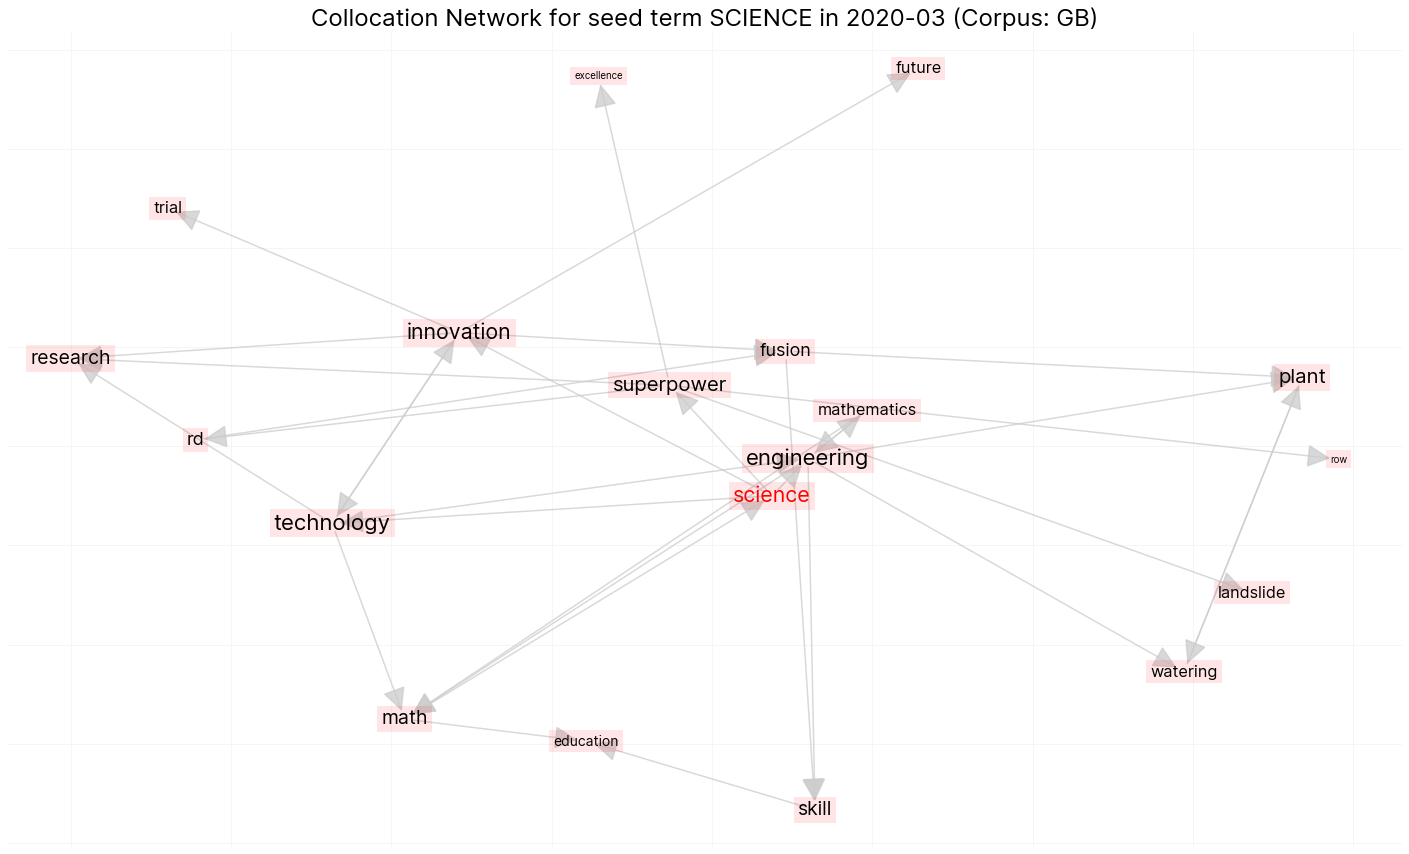

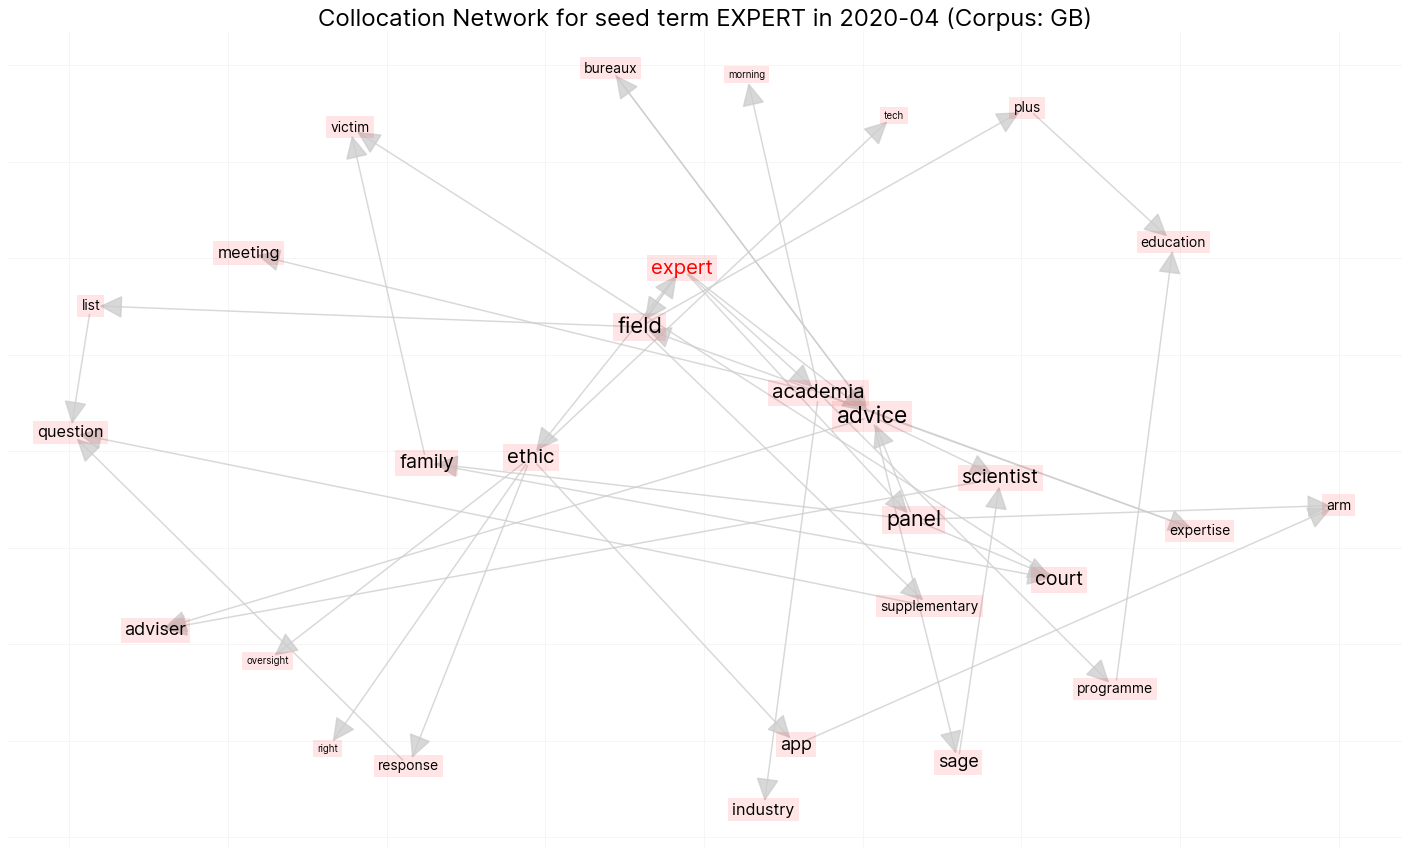

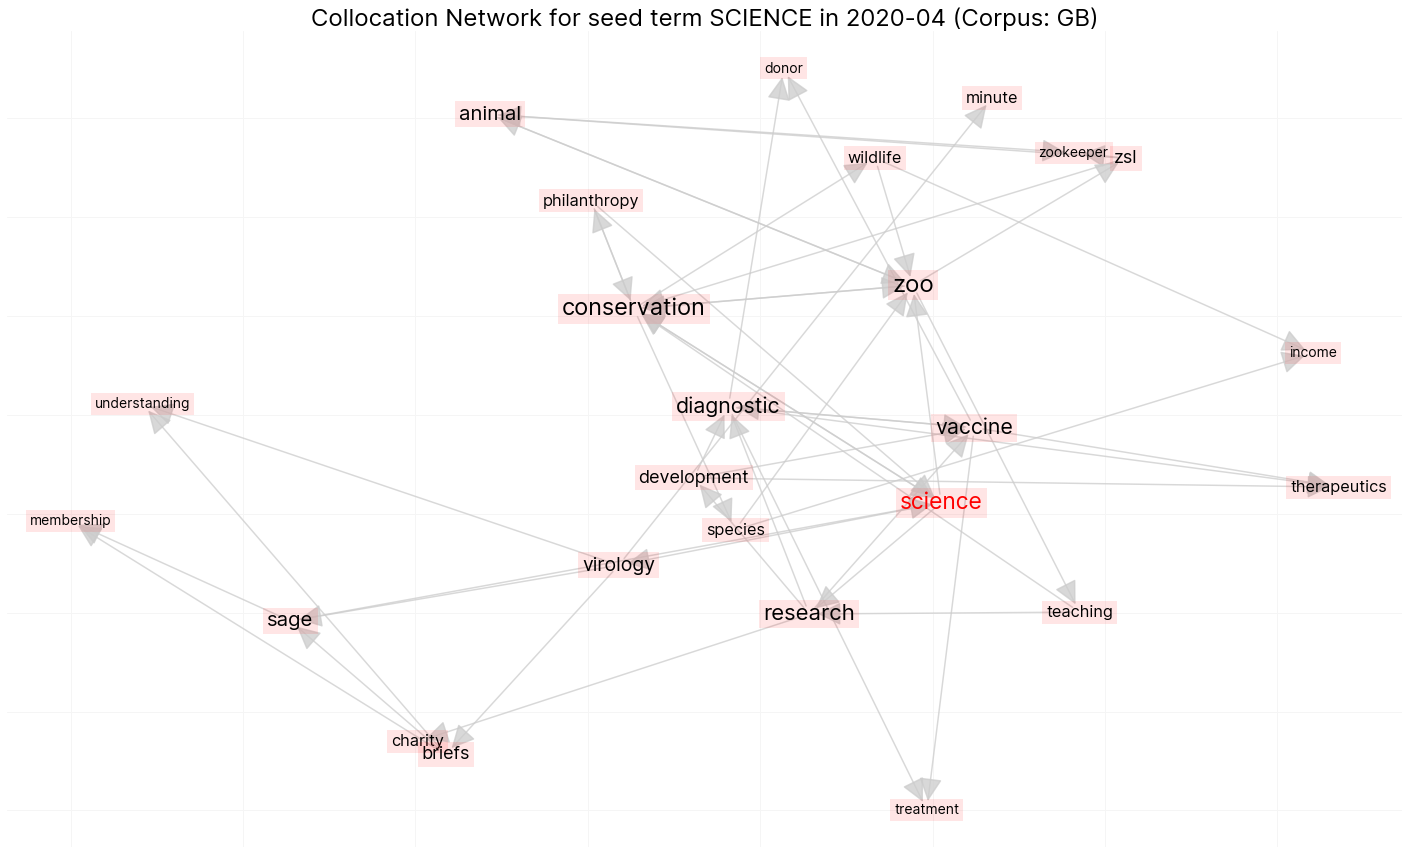

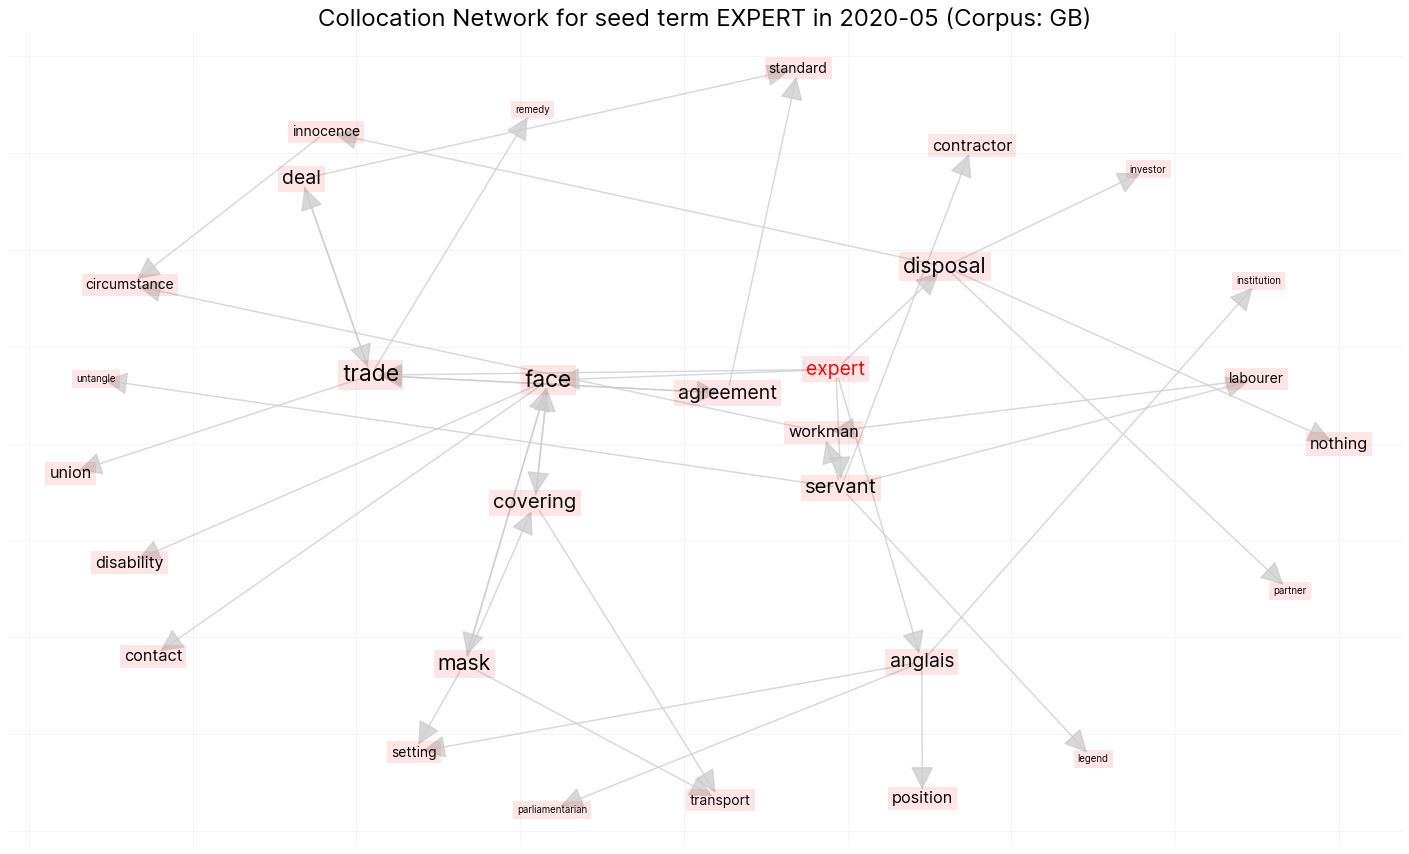

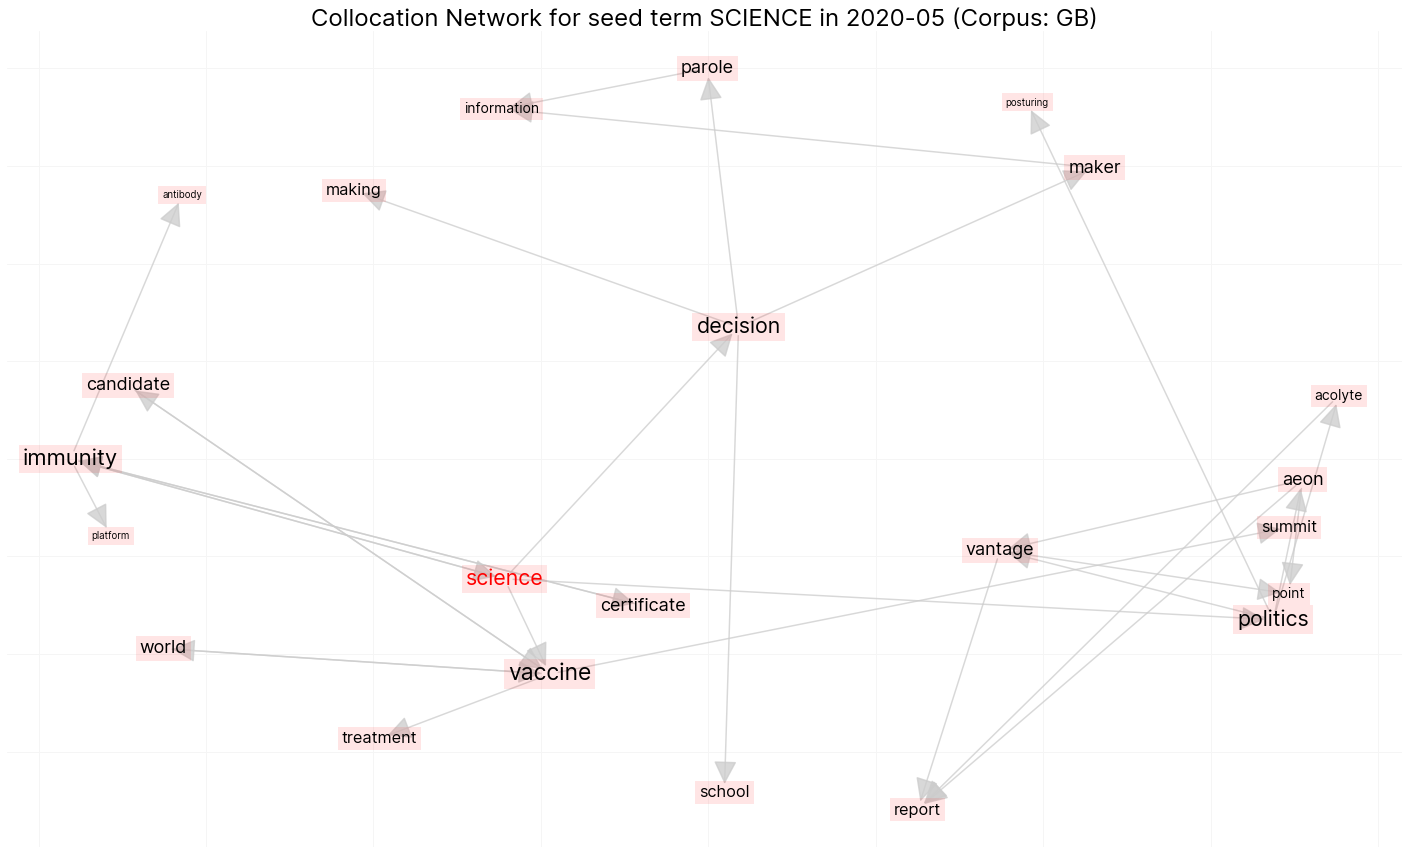

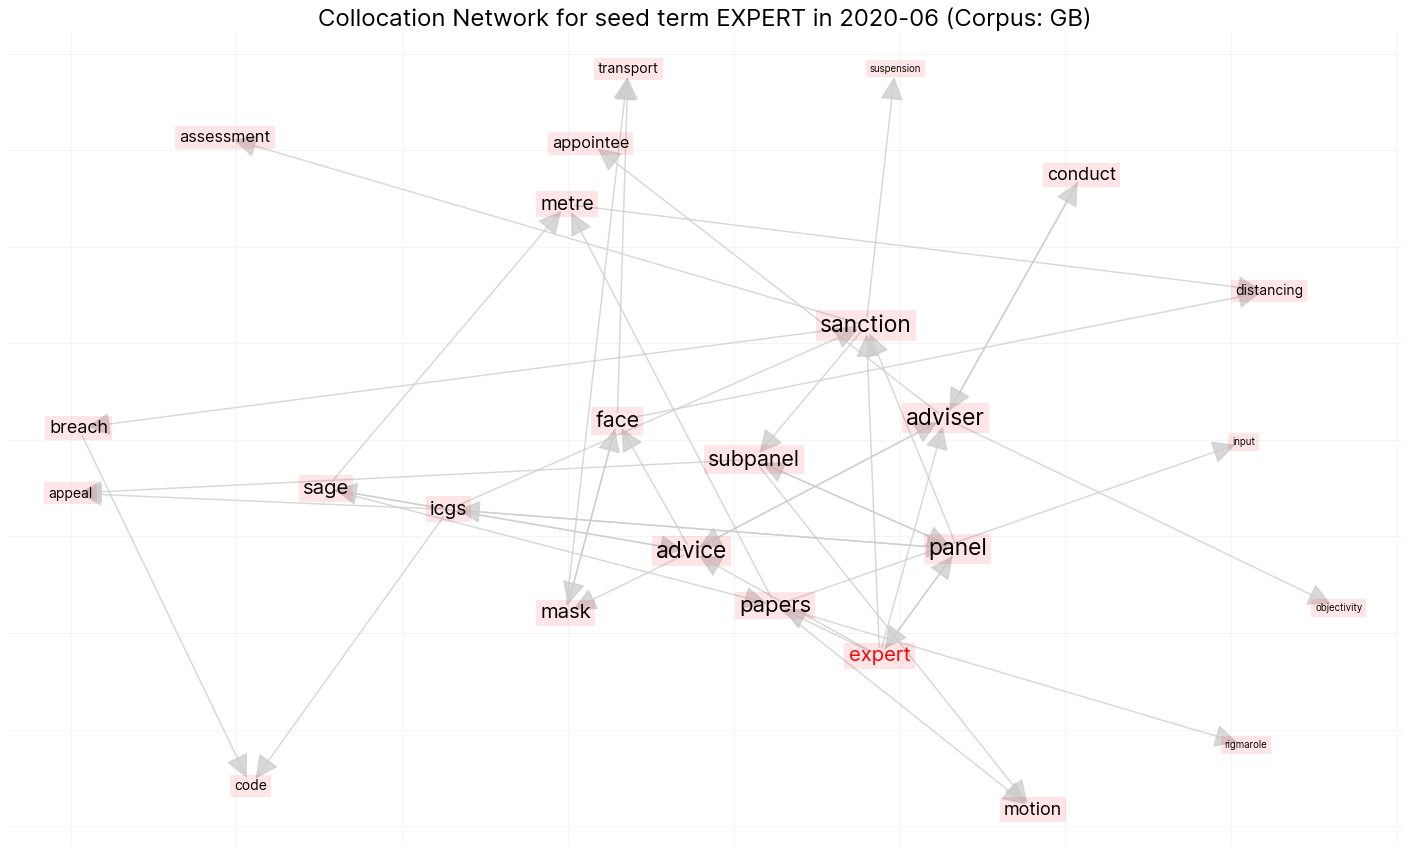

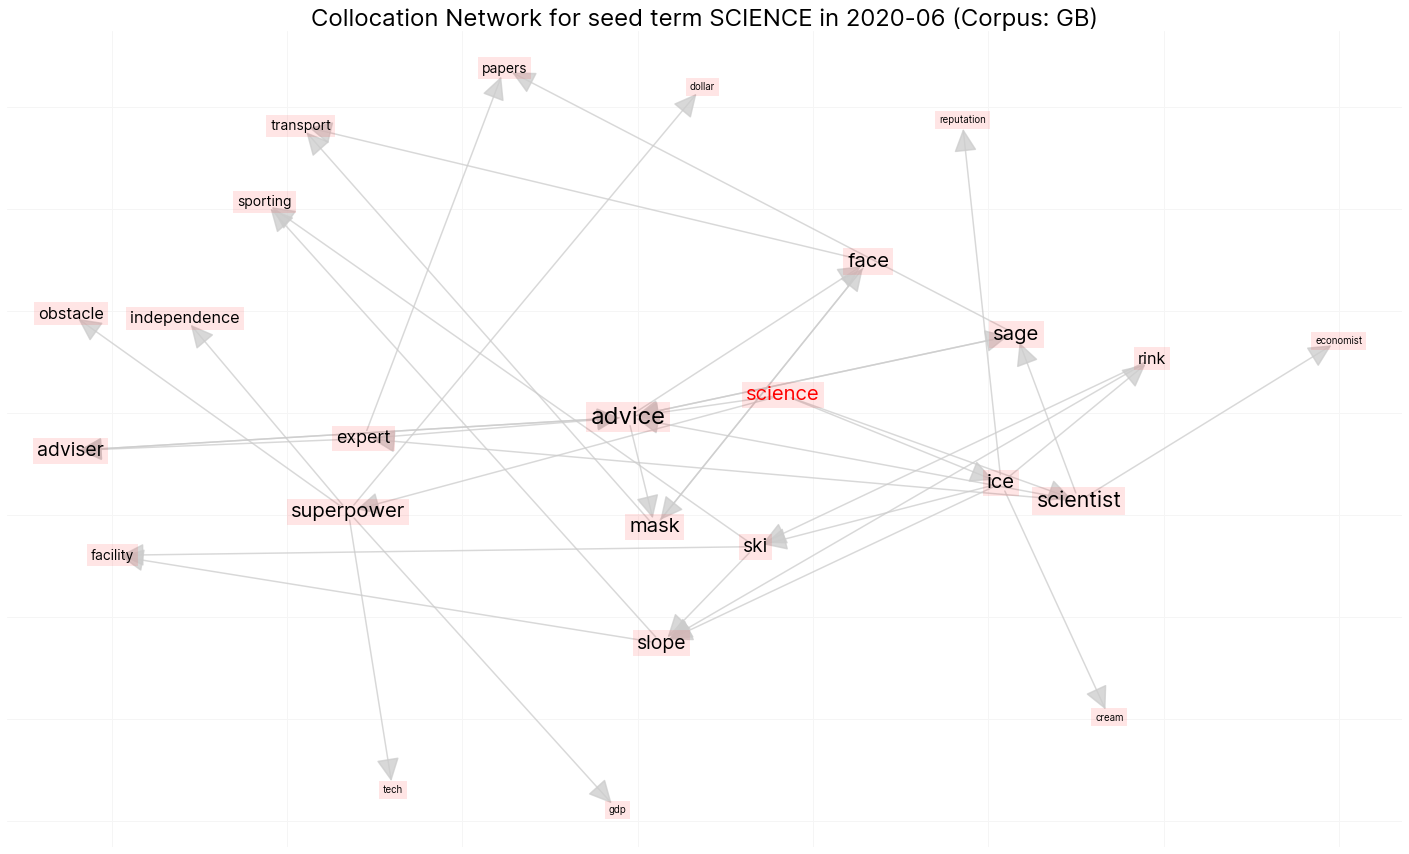

In [10]:
for iso,language in [('nl','dutch'),('it','italian'),('gb','english')]:
    df = clean_subset(iso,language)
    for month in ["2020-03","2020-04","2020-05","2020-06"]:
        
        for term in ['expert','science']:
            collocation_month(iso,df,month=month,seed_term=tf_science[iso][term],window_size=5,topn=5,plot=True,degree_limit=2)

In [34]:
# Get top collocates per month per coalition-opposition, using only nouns

for iso,language in [('nl','dutch'),('it','italian'),('gb','english')]:
    df = clean_subset(iso,language)
    result = pd.DataFrame()

    for month in ["2020-03","2020-04","2020-05","2020-06"]:
        tdf = df[(df['id'].str.contains(month))]
        for group in ['coalition','opposition']:
            print(month,group)
            tdfg = tdf[tdf['party_status'] == group]
            text = list(tdfg['text'])
            text = " ".join(text).split(' ')
            len_ = len([w for w in text if w  == tf_science[iso]['expert']])
            if len_ < 5:
                continue
            finder = BigramCollocationFinder.from_words(text,window_size=5)
            result[month + "_" + group + f"(n={len_})"] = find_top_collocates(finder, set(text), tf_science[iso]['expert'], 15)
    result.to_csv(f'/home/ruben/Documents/GitHub/ParlaMintCase/results/tables/coalopp-topcollocates-expert-{iso}-ws5-alldata.csv',index=False)

100%|██████████| 61573/61573 [00:03<00:00, 17005.61it/s]
size after subsetting: 61573
2020-03 coalition
2020-03 opposition
2020-04 coalition
2020-04 opposition
2020-05 coalition
2020-05 opposition
2020-06 coalition
2020-06 opposition
100%|██████████| 5204/5204 [00:03<00:00, 1713.28it/s]
size after subsetting: 5204
2020-03 coalition
2020-03 opposition
2020-04 coalition
2020-04 opposition
2020-05 coalition
2020-05 opposition
2020-06 coalition
2020-06 opposition
100%|██████████| 108354/108354 [00:16<00:00, 6447.94it/s]
size after subsetting: 108354
2020-03 coalition
2020-03 opposition
2020-04 coalition
2020-04 opposition
2020-05 coalition
2020-05 opposition
2020-06 coalition
2020-06 opposition


In [32]:
len_

0